### OK lets go back through bigram

we've learned a bit about setting up tensors and batches and I just want to lock in some of the ideas 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
%run ../lib/bookreader.py

In [5]:
names = BookReader()
names.read("../resources/names.txt")
vocab_size = names.vocab_size
vocab_size

lowercase only


27

jsut spell out the mapping from characters to their simple 1D embedding:

In [6]:
print("number of symbols", names.vocab_size, "lengths of our train, dev, test splits", len(names.data[0]), len(names.data[1]), len(names.data[2]))

symbols = ""
for i, c in enumerate(names.chars):
    symbols += f"{i}:{c}, "

symbols

number of symbols 27 lengths of our train, dev, test splits 183300 21600 23025


'0:\n, 1:a, 2:b, 3:c, 4:d, 5:e, 6:f, 7:g, 8:h, 9:i, 10:j, 11:k, 12:l, 13:m, 14:n, 15:o, 16:p, 17:q, 18:r, 19:s, 20:t, 21:u, 22:v, 23:w, 24:x, 25:y, 26:z, '

## batch stuff again 

In [7]:
def get_labeled_batch(data, context_length=1, label_length=1, batch_size=5):
    # generate a small batch of data of inputs x and targets y
    ix = torch.randint(len(data) - context_length, (batch_size,))
    b = torch.stack([data[i:i+context_length+label_length] for i in ix])
    
    x = b[:, 0:context_length]
    y = b[:, context_length:context_length+label_length]
    return x, y

In [8]:
train = torch.tensor(names.data[0])
t_b = get_labeled_batch(train)
t_b

(tensor([[12],
         [14],
         [ 3],
         [ 1],
         [12]]),
 tensor([[12],
         [15],
         [ 8],
         [19],
         [25]]))

In [9]:
bigram_weights = torch.randn(vocab_size, vocab_size)
bigram_weights.shape

torch.Size([27, 27])

In [10]:
bigram_encoded = F.one_hot(t_b[0], num_classes=27)
t_b[0], bigram_encoded

(tensor([[12],
         [14],
         [ 3],
         [ 1],
         [12]]),
 tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0]],
 
         [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0]],
 
         [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 0, 0, 0]]]))

## just go over that one_hot stuff

so thinking about the interactions of the one_hot and the bigram weight again

each example in the batch picks out a single row in the bigram weights

In [11]:
one_row = F.one_hot(t_b[0][0], num_classes=vocab_size)
bigram_weights[:, 0], one_row * bigram_weights[:4]

(tensor([ 0.3541, -0.3201, -0.3401,  0.2690,  0.3055, -0.3056,  1.0199, -1.2648,
          1.7387, -0.6993, -0.4494, -0.3260,  0.8690,  0.2729, -0.3548, -0.2096,
         -0.8791,  0.3454, -0.1465,  0.8456,  0.9477,  0.6807, -0.7641,  0.1982,
         -0.1490, -0.8013, -0.7173]),
 tensor([[ 0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000,
          -0.0000,  0.0000, -0.0000, -0.0000, -1.0666,  0.0000,  0.0000,  0.0000,
           0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,
           0.0000, -0.0000,  0.0000],
         [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
          -0.0000, -0.0000,  0.0000, -0.0000, -0.3318, -0.0000,  0.0000,  0.0000,
           0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000,
          -0.0000,  0.0000, -0.0000],
         [-0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
          -0.0000,  0.0000,  0.0000,  0.0000, -0.7716, -0.0000,  0.00

so the prediction will only function across those weights, they're the only things that go into forming the prediction

lets set it up so we imagine all the names are 'alice' so 'a' is always followed by 'l'

In [12]:
bigram_weights.requires_grad = True

the_a_row = F.one_hot(torch.tensor(names.encode('a')), num_classes=27)

logits = bigram_weights * the_a_row

print(bigram_weights.shape, the_a_row.shape, logits.shape)

the_expected_answer = F.one_hot(torch.tensor(names.encode('l')), num_classes=27)
print(the_expected_answer, the_expected_answer.shape)

loss = F.cross_entropy(logits, the_expected_answer.view(-1))

bigram_weights.grad = None
loss.backward()
bigram_weights.grad[:, names.encode('a')].T, bigram_weights.grad[:4]

torch.Size([27, 27]) torch.Size([1, 27]) torch.Size([27, 27])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]]) torch.Size([1, 27])


(tensor([[ 2.4991e-03,  3.4836e-04,  6.5716e-04,  1.9820e-03,  4.4591e-04,
           1.9402e-03,  9.4219e-04,  1.4633e-03,  6.3191e-03,  1.8428e-02,
           9.1579e-05,  1.6926e-03, -3.4510e-02,  1.8812e-03,  3.2318e-03,
           1.6203e-03,  3.1105e-04,  8.8817e-04,  5.7903e-03,  4.1110e-03,
           6.1033e-04,  5.5342e-03,  1.5140e-03,  1.2462e-03,  3.2354e-04,
           1.4253e-03,  6.1292e-04]]),
 tensor([[-0.0000, 0.0025, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [-0.0000, 0.0003, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [-0.0000, 0.0007, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
       

we can see the only gradient is on the 'a' weights in the system

## now lets train some batches

by batching we can speed up our tensor calculations (well if we used a gpu or metal or whatever)

In [13]:
xs, ys = get_labeled_batch(train, 1, 1, 3)
print(xs.shape, ys.shape)
o_h = F.one_hot(xs, num_classes=vocab_size)
labels = F.one_hot(ys, num_classes=vocab_size)
print("xs", o_h)
print("ys", labels)

torch.Size([3, 1]) torch.Size([3, 1])
xs tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]]])
ys tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
          0, 0, 0, 0]]])


In [14]:
epochs = 20
training_runs = 400
batch_size = 80
learning_rate = .5
bigram_weights = torch.randn((vocab_size, vocab_size), requires_grad=True)
for ep in range(epochs):
    epoch_loss = 0
    for tr in range(training_runs):
        xs, ys = get_labeled_batch(train, 1, 1, batch_size)
        o_h = F.one_hot(xs, num_classes=vocab_size).float()
        logits = o_h @ bigram_weights
        labels = F.one_hot(ys, num_classes=vocab_size)
    
        # reshape because of batches
        r_logits = logits.view(-1, vocab_size) 
        r_labels = labels.view(-1, vocab_size)
    
        probs = F.softmax(r_logits, 1) 
        loss = -(r_labels * probs).sum(1).log().mean()

        epoch_loss += loss
    
        bigram_weights.grad = None
        loss.backward()
        bigram_weights.data -= learning_rate * bigram_weights.grad

    print("epoch loss", epoch_loss/training_runs)

epoch loss tensor(3.1933, grad_fn=<DivBackward0>)
epoch loss tensor(2.8015, grad_fn=<DivBackward0>)
epoch loss tensor(2.6802, grad_fn=<DivBackward0>)
epoch loss tensor(2.6144, grad_fn=<DivBackward0>)
epoch loss tensor(2.5844, grad_fn=<DivBackward0>)
epoch loss tensor(2.5656, grad_fn=<DivBackward0>)
epoch loss tensor(2.5393, grad_fn=<DivBackward0>)
epoch loss tensor(2.5248, grad_fn=<DivBackward0>)
epoch loss tensor(2.5264, grad_fn=<DivBackward0>)
epoch loss tensor(2.5156, grad_fn=<DivBackward0>)
epoch loss tensor(2.5043, grad_fn=<DivBackward0>)
epoch loss tensor(2.4924, grad_fn=<DivBackward0>)
epoch loss tensor(2.4977, grad_fn=<DivBackward0>)
epoch loss tensor(2.4945, grad_fn=<DivBackward0>)
epoch loss tensor(2.4851, grad_fn=<DivBackward0>)
epoch loss tensor(2.4900, grad_fn=<DivBackward0>)
epoch loss tensor(2.4837, grad_fn=<DivBackward0>)
epoch loss tensor(2.4835, grad_fn=<DivBackward0>)
epoch loss tensor(2.4816, grad_fn=<DivBackward0>)
epoch loss tensor(2.4860, grad_fn=<DivBackward0>)


### look at train vs dev

we want to compare our training loss to the loss on a set of names we haven't yet looked at 

- we either skipped this first time through or it's covered in a later lecture

In [15]:
@torch.no_grad()
def split_loss(set):
    eval_loss = 0
    set_len = len(set)
    for i in range(set_len-1):
        o_h = F.one_hot(set[i], num_classes=vocab_size).float()
        logits = o_h @ bigram_weights
        labels = F.one_hot(set[i+1], num_classes=vocab_size)
        probs = F.softmax(r_logits, 1) 
        eval_loss += -(r_labels * probs).sum(1).log().mean()

    return eval_loss/set_len

In [ ]:
dev = torch.tensor(names.data[1])

dev_loss = split_loss(dev)
print("dev split", dev_loss)
train_loss = split_loss(train)
print("train split", train_loss)

dev split tensor(2.5858)


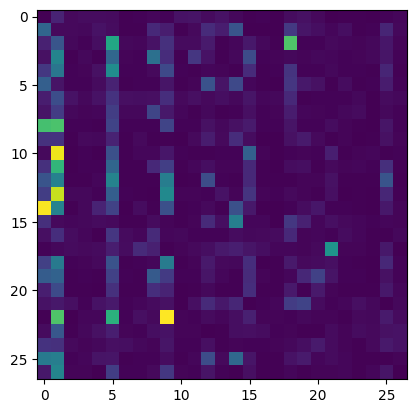

In [15]:
import matplotlib.pyplot as plt
wplot = bigram_weights.exp().data
plt.imshow(wplot)